In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics

In [16]:
#import data
bhbh = pd.read_csv('BHBH.csv')
#fill na
bhbh.fillna(0)

,Unnamed: 0,name,Mass_0,Z_0,Mass_1,a,e,Mass_0_out,Mass_1_out,GWtime,BWorldtime,RLO,CE,tdelay,Mass_max_out,q,Mass_chirp
0,0,0_892687128228499,34.044,0.0001,26.514,1850.0,0.0535,33.47953,10.136270,1.063429e+11,6.826057,0.0,2.0,1.063429e+11,10.136270,0.302760,15.504785
1,1,0_853530625884132,72.066,0.0001,27.308,2980.0,0.6550,35.86105,6.408674,5.383296e+05,6.673187,1.0,1.0,5.383363e+05,6.408674,0.178708,12.348916
2,2,0_663761388951870,45.129,0.0001,43.875,8900.0,0.8860,44.50211,43.256140,2.696385e+10,4.636688,0.0,0.0,2.696385e+10,43.256140,0.972002,38.194377
3,3,0_288577009013924,91.090,0.0001,53.664,7730.0,0.6940,38.06668,53.322640,1.109533e+11,4.094508,1.0,0.0,1.109533e+11,38.066680,0.713893,39.110638
4,4,0_736350695048425,53.827,0.0001,38.009,15200.0,0.0196,53.10823,37.424980,4.710726e+13,5.119633,0.0,0.0,4.710726e+13,37.424980,0.704693,38.693005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81888,331,0_133330331314376,24.346,0.0100,24.215,7570.0,0.0716,20.10294,20.050940,5.588582e+13,7.316824,0.0,0.0,5.588582e+13,20.050940,0.997413,17.477974
81889,332,0_386148050098142,119.702,0.0100,84.740,81600.0,0.3620,41.13939,34.333730,1.901373e+18,3.272379,0.0,0.0,1.901373e+18,34.333730,0.834571,32.691048
81890,333,0_272337824410863,56.315,0.0100,34.050,11500.0,0.6130,23.80512,22.512770,2.610532e+14,5.458789,0.0,0.0,2.610532e+14,22.512770,0.945711,20.151614
81891,334,0_862589532557700,104.790,0.0100,44.480,93300.0,0.6480,38.47061,20.186010,1.457729e+18,4.544498,0.0,0.0,1.457729e+18,20.186010,0.524713,24.012884


In [21]:
#add column label
n_bins = 200

# Define the edges between bins
counts, bin_edges = np.histogram(bhbh.q.values, bins=n_bins, range=(0.0,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = pd.cut(bhbh['q'].values, bins=bin_edges, right=True, labels=False, include_lowest=False)

print('bin_edges:', len(bin_edges))
print(counts)

np.unique(np.array(bhbh['label']))

bin_edges: 201
[   0    0    0    0    0    0    0    0    0    0    0    0    0    1
    0    0    0    0    0    0    2    2    3    2    4    8    9   27
   25   31   22   27   49   33   49   39   55   46   68   51   72   67
   62   56   58   61   82   88   64   76   82   80   71   99   79  113
  114  130  107  106  129  115  124  105  122  136  143  143  163  132
  121  163  161  140  158  152  209  186  228  207  241  205  223  230
  209  216  216  257  255  283  307  294  281  288  310  294  328  315
  319  338  293  313  319  357  334  351  333  354  389  359  428  411
  392  413  420  459  432  461  420  454  473  454  516  447  496  485
  501  516  560  537  531  536  547  569  564  577  592  567  633  627
  596  635  654  602  700  642  656  655  652  652  698  664  666  709
  697  680  645  725  739  700  669  699  690  780  707  735  777  735
  744  769  767  840  808  771  872  887  863  892  874  880  924  927
  983  938 1025 1063 1125 1137 1158 1198 1196 1237 1246 1206 1

array([ 13,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 19

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        8.000e+00, 9.000e+00, 0.000e+00, 2.700e+01, 2.500e+01, 3.100e+01,
        2.200e+01, 2.700e+01, 4.900e+01, 3.300e+01, 4.900e+01, 3.900e+01,
        5.500e+01, 4.600e+01, 6.800e+01, 5.100e+01, 0.000e+00, 7.200e+01,
        6.700e+01, 6.200e+01, 5.600e+01, 5.800e+01, 6.100e+01, 8.200e+01,
        8.800e+01, 6.400e+01, 7.600e+01, 8.200e+01, 8.000e+01, 7.100e+01,
        0.000e+00, 9.900e+01, 7.900e+01, 1.130e+02, 1.140e+02, 1.300e+02,
        1.070e+02, 1.060e+02, 1.290e+02, 1.150e+02, 1.240e+02, 1.050e+02,
        1.220e+02, 1.360e+02, 1.430e+02, 0.000e+00, 1.430e+02, 1.630e+02,
        1.320e+02, 1.210e+02, 1.630e+02, 1.610e+02, 1.400e+02, 1.580e+02,
        1.520e+02, 2.090e+02, 1.860e+02, 2.280e+02, 2.070e+02, 0.000e+00,
        2.410e+02, 2.050e+02, 2.230e+02, 2.300e+02, 2.090e+02, 2.160e+02,
        2.160e+02, 2.570e+02, 2.550e+0

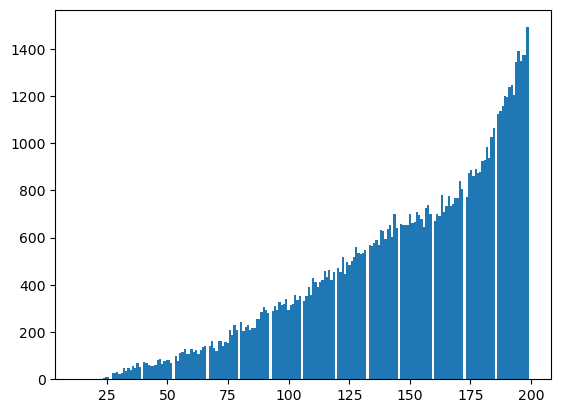

In [22]:
plt.hist(bhbh['label'], bins=n_bins)

In [23]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=bhbh['label'] 
)

## Model data and parameters

In [6]:
#Data
X = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'a', 'e']]
le = LabelEncoder()
#y = le.fit_transform(bhbh['label'])
y = bhbh['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

y_train = le.fit_transform(y_train)
#weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)


#parameters
n_estimators = 10
max_depth = 8
learning_rate = 0.3
grow_policy = 0
max_leaves = n_bins

param = {'objective': 'multi:softprob',
        'n_estimators' : 10, 
        'max_depth' : 2,
        'learning_rate' : 0.3,
        'grow_policy' : 0,
        #'max_leaves' : n_bins,
         'num_class': n_bins,
        'n_jobs' : -1
        }

In [7]:
model = XGBClassifier(param)

/home/vepe/miniconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [8]:
np.unique(np.array(y))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
prediction = model.predict(X_train)
#prediction = le.inverse_transform(prediction)

In [11]:
prediction.shape, X_train.shape

((57325,), (57325, 5))

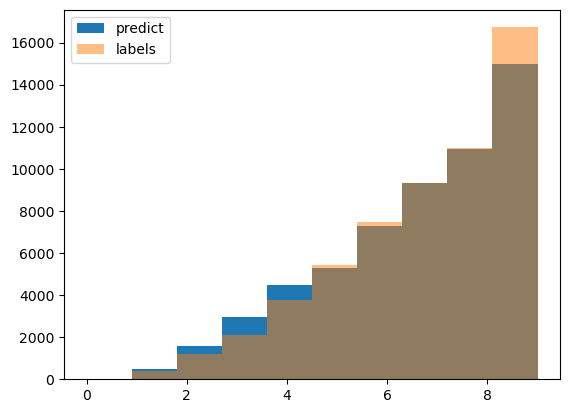

In [12]:
plt.hist(prediction, bins=n_bins, alpha=1, label='predict')
plt.hist(y_train, alpha=0.5, bins=n_bins, label='labels')
plt.legend()

5 8


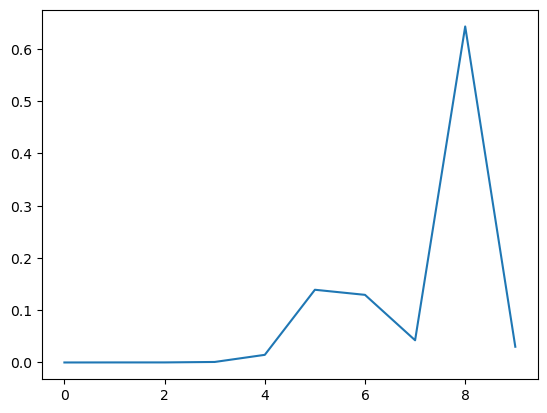

In [13]:
prob_y_pred = model.predict_proba(X_train)
prob_y_pred.shape

k = 5
plt.plot(range(0,n_bins), prob_y_pred[k])
print(y[k], prediction[k])

In [14]:
y_pred = model.predict(X_test)
#y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(accuracy_score(y_test, y_pred, normalize=True))
print(accuracy_score(y_train, prediction))

[[   0    0    0    0    0    0    0    0    0    0]
 [   0  107   49    8    8    1    1    1    0    0]
 [   0   30  341   67   13   13    7    4    1    3]
 [   0   14  101  638   98   54   13    6    3   14]
 [   0   15   46  280  998  187   51   34   30   22]
 [   0   31   48  141  353 1201  314   82   50   36]
 [   0   10   36   80  201  384 1873  449  131  107]
 [   1    3   33   53  116  174  503 2425  573  156]
 [   0    5   19   45  106   90  202  721 2929  672]
 [   0    3   17   49   83   81  189  319 1026 5190]]
0.639124063822859
0.7640819886611426
